# Least Squares Algorithms: Examples

In [1]:
import os
os.chdir('../src/')

from industryts.generation.synthetic import ar_process
from industryts.models.optimization import LeastSquaresOptimizer

import numpy as np
from rich import print, pretty, traceback
import matplotlib.pyplot as plt

pretty.install()

rng = np.random.default_rng(2511)

We start by generating random data that will be used in model training.

In [2]:
# Some tests

# Number of samples
n = 100
# Dimensionality of the regressors
p = 3

# Create a matrix of regressors, where each column is an AR(1) process
regressors = np.array(
    [ar_process(coefs=0.98, samples=n, noise=0.05) for _ in range(p)]).T

# Create a vector of targets with known coefficients.
coefs = rng.normal(size=(p, 1))*10
targets = regressors @ coefs

# Add some noise to the targets
targets += rng.normal(scale=0.2, size=(n, 1))


We then train the coefficients and print the results, as well as the true coefficients.

In [3]:
# OLS
ols = LeastSquaresOptimizer(method="OLS")
ols.fit(regressors, targets)

# RLS
rls = LeastSquaresOptimizer(method="RLS")
history, _ = rls.fit(
    regressors, targets, return_history=True, limit_covariance_trace=1e-3)

print("True coefficients:")
print([f"{c:.2f}" for c in coefs.flatten()])
print("OLS coefficients:")
print([f"{c:.2f}" for c in ols.coefs.flatten()])
print("RLS coefficients:")
print([f"{c:.2f}" for c in rls.coefs.flatten()])

True coefficients:

['5.49', '-14.52', '-1.67']

OLS coefficients:

['5.49', '-14.53', '-1.68']

RLS coefficients:

['5.49', '-14.53', '-1.68']

We can also see how the RLS coefficients converged over time.

Text(0, 0.5, 'Coefficient value')

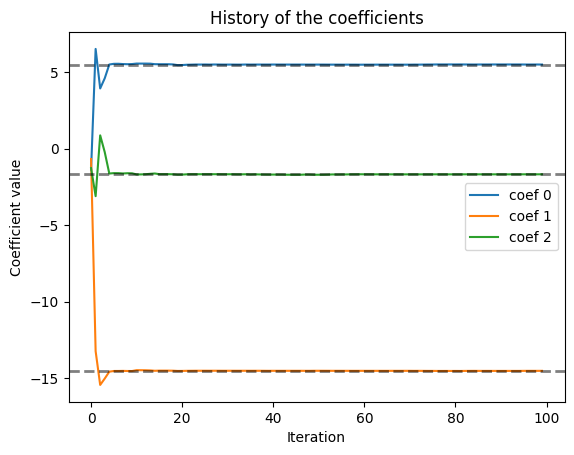

In [4]:
# Plot the history of the coefficients
fig, ax = plt.subplots()

for i in range(p):
    ax.plot(history[:, i], label=f"coef {i}")

# Add straight lines for the true coefficients
for i in range(p):
    ax.axhline(coefs[i], linestyle="--", color="black", xmin=0, xmax=1,
               linewidth=2, alpha=0.5)

ax.legend()
ax.set_title("History of the coefficients")
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")


We feed more data to the already fitted model, to show that the trained coefficients are preserved.

In [5]:
regressors = np.array(
    [ar_process(coefs=0.98, samples=n, noise=0.05) for _ in range(p)]).T

targets = regressors @ coefs + rng.normal(scale=0.2, size=(n, 1))

# RLS
history_continuation, _ = rls.fit(
    regressors, targets, return_history=True, limit_covariance_trace=1e-3)

Text(0, 0.5, 'Coefficient value')

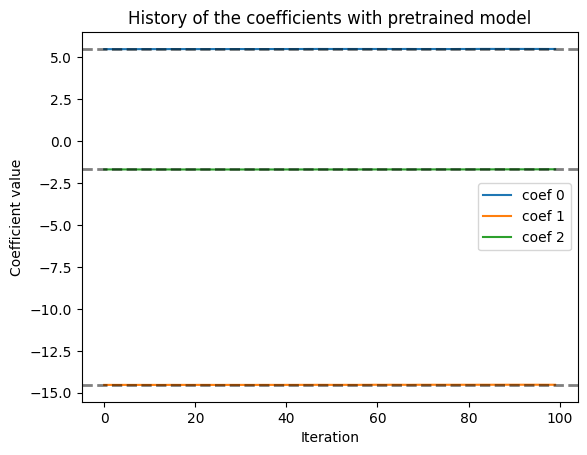

In [6]:
fig, ax = plt.subplots()
for i in range(p):
    ax.plot(history_continuation[:, i], label=f"coef {i}")
for i in range(p):
    ax.axhline(coefs[i], linestyle="--", color="black", xmin=0, xmax=1,
               linewidth=2, alpha=0.5)
ax.legend()
ax.set_title("History of the coefficients with pretrained model")
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")

We experiment with adding drift to the process, changing the true coefficients. The model is expected to adapt to the new coefficients.

In [7]:
regressors = np.array(
    [ar_process(coefs=0.98, samples=2*n, noise=0.05) for _ in range(p)]).T

targets = regressors @ coefs

# At the halfway point, change the coefficients to simulate a drift
targets[n:] = regressors[n:] @ (coefs + 3)

targets += rng.normal(scale=0.2, size=(2*n, 1))

In [8]:
history_drift, _ = rls.fit(
    regressors, targets,
    return_history=True, forgetting_factor=0.96, limit_covariance_trace=1e-3)

Text(0, 0.5, 'Coefficient value')

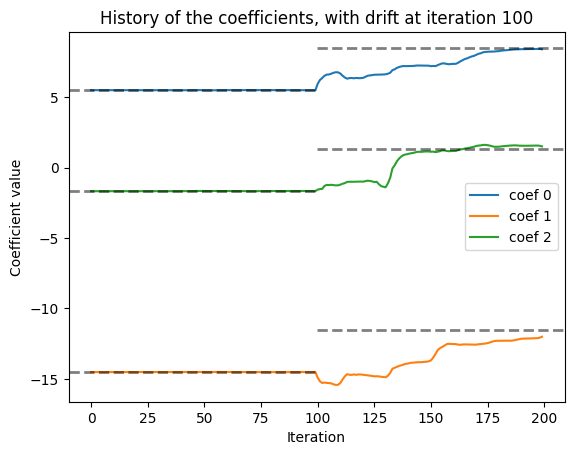

In [9]:
fig, ax = plt.subplots()
for i in range(p):
    ax.plot(history_drift[:, i], label=f"coef {i}")
for i in range(p):
    ax.axhline(coefs[i], linestyle="--", color="black", xmin=0, xmax=0.5,
               linewidth=2, alpha=0.5)
    ax.axhline(coefs[i]+3, linestyle="--", color="black", xmin=0.5, xmax=1,
               linewidth=2, alpha=0.5)


ax.legend()
ax.set_title(f"History of the coefficients, with drift at iteration {n}")
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")